In [6]:
# Code to read csv file into Colaboratory:
!pip install -U -q PyDrive
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials
import pandas as pd
# Authenticate and create the PyDrive client.
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)
link = 'https://drive.google.com/open?id=1eHJotrWj-DfflTBQQoZcc9f8zJyinkX_' # The shareable link
fluff, id = link.split('=')
# print (id) # Verify that you have everything after '='
downloaded = drive.CreateFile({'id':id}) 
downloaded.GetContentFile('train.csv')  
df = pd.read_csv('train.csv')
# Dataset is now stored in a Pandas Dataframe

/usr/local/lib/python3.7/dist-packages/IPython/core/interactiveshell.py:2718: DtypeWarning: Columns (135,204,274,417) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


### Import Libraries

In [7]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import *
from sklearn import metrics
from sklearn.metrics import *
from sklearn.svm import SVC
from sklearn.compose import ColumnTransformer
from sklearn.feature_selection import SelectKBest, mutual_info_classif, f_classif
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import *
from sklearn.linear_model import LogisticRegression
from sklearn.svm  import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier

In [8]:
df.head()

,id,f1,f2,f3,f4,f5,f6,f7,f8,f9,f10,f13,f14,f15,f16,f17,f18,f19,f20,f21,f22,f23,f24,f25,f26,f27,f28,f29,f30,f31,f32,f33,f34,f35,f36,f37,f38,f39,f40,f41,...,f740,f741,f742,f743,f744,f745,f746,f747,f748,f749,f750,f751,f752,f753,f754,f755,f756,f757,f758,f759,f760,f761,f762,f763,f764,f765,f766,f767,f768,f769,f770,f771,f772,f773,f774,f775,f776,f777,f778,loss
0,1,126,10,0.686842,1100,3,13699,7201.0,4949.0,126.75,126.03,7,0.7607,0.7542,612922,0.7236,0.7236,0.5171,0.7236,0.8476,0.7876,1.097851e+09,89,66,998046.0,89.0,89.0,89.00,89.00,89.0,0.9271,0,0,0,5,0,0,0.73180,0.72124,0.749280,...,-4.40,6,9.76,-21.82,49.18,1.0435,-0.9066,1.5883,3.4154,2.8283,2.3451,0.030594,1.7418,1.5271,0.8474,0.4715,0.028362,3.1611,2.5162,2.0037,0.019636,4.4352,4.2676,-0.1524,1,-0.40,-0.560,-0.440,-0.6280,-3.14,5,2.14,-1.54,1.18,0.1833,0.7873,1,0,5,0
1,2,121,10,0.782776,1100,3,84645,240.0,1625.0,123.52,121.35,7,0.6555,0.6555,245815,0.6341,0.6341,0.3909,0.6667,0.6903,0.6903,8.449459e+08,78,50,754416.0,78.0,78.0,78.00,78.00,78.0,0.8478,0,0,0,6,0,0,0.65705,0.64069,0.626200,...,0.35,7,51.73,-72.44,798.74,2.7180,-0.8294,1.0740,2.9194,2.1180,1.5666,0.120442,1.1963,1.0322,0.4843,0.2389,0.130160,2.7659,1.9523,1.4059,0.115277,3.2763,2.7962,-0.3097,1,-0.17,-0.275,-0.203,-0.2300,-1.38,6,0.54,-0.24,0.13,0.1926,-0.6787,1,0,5,0
2,3,126,10,0.500080,1100,3,83607,1800.0,1527.0,127.76,126.49,7,0.7542,0.7542,1385872,0.7542,0.7542,0.5508,0.7542,0.8091,0.7807,1.308478e+09,89,54,1037651.0,89.0,89.0,100.43,94.37,89.0,0.9175,0,0,0,13,0,0,0.74710,0.75878,0.654685,...,-6.35,14,56.62,-79.48,621.97,1.9592,-0.3632,3.2969,7.2072,5.7062,4.5627,0.226336,3.3277,3.4166,1.8321,0.9979,0.103307,6.8623,5.2963,4.1282,0.219729,8.1381,7.3269,-0.1909,1,-0.58,-0.540,-0.572,-0.3985,-5.18,13,2.89,-1.73,1.04,0.2521,0.7258,1,0,5,0
3,4,134,10,0.439874,1100,3,82642,7542.0,1730.0,132.94,133.58,7,0.8017,0.7881,704687,0.7881,0.7881,0.5923,0.7881,0.8230,0.8158,1.472752e+09,93,55,1115721.0,93.0,93.0,114.63,102.92,93.0,0.9688,0,0,0,4,0,0,0.77405,0.78929,0.750675,...,3.75,5,36.31,18.15,429.81,2.5883,-0.8812,1.2950,2.5777,2.0830,1.6899,0.054630,1.3748,1.3421,0.7982,0.4810,0.081205,2.5571,2.0593,1.6653,0.056470,3.2516,3.0631,-0.1770,1,-0.75,-0.635,-0.745,-0.5100,-2.04,4,1.29,-0.89,0.66,0.2498,0.7119,1,0,5,0
4,5,109,9,0.502749,2900,4,79124,89.0,491.0,122.72,112.77,6,0.5263,0.5263,51985,0.5263,0.5263,0.3044,0.5405,0.5556,0.5455,1.442916e+09,60,21,536400.0,60.0,60.0,60.00,60.00,60.0,0.8451,0,0,0,26,0,0,0.60315,0.53367,0.696150,...,11.45,27,2206.14,-10559.05,708436.49,9.0293,-0.8760,6.3852,17.2599,14.2795,11.9179,0.085330,7.2175,6.2262,3.1446,1.6149,0.074286,15.9080,12.5688,9.9844,0.067540,17.5561,15.6079,-0.4444,1,-0.18,-0.280,-0.182,-0.4277,-11.12,26,6.11,-3.82,2.51,0.2282,-0.5399,0,0,5,0


In [9]:
df.shape

(105471, 771)

In [10]:
df.columns

Index(['id', 'f1', 'f2', 'f3', 'f4', 'f5', 'f6', 'f7', 'f8', 'f9',
       ...
       'f770', 'f771', 'f772', 'f773', 'f774', 'f775', 'f776', 'f777', 'f778',
       'loss'],
      dtype='object', length=771)

## Data Exploration

In [11]:
df['loss'].unique()

array([  0,   1,  16,  19,   4,  11,  21,   2,   9,   5,   3,   7,  13,
         6,  25,  44,  17, 100,  10,   8,  65,  15,  12,  29,  22,  20,
        18,  41,  55,  28,  23,  14,  38,  42,  33,  27,  24,  39,  26,
        31,  35,  64,  32,  54,  37,  61,  79,  51,  43,  77,  47,  36,
        46,  81,  78,  60,  45,  85,  84,  34,  90,  40,  50,  92,  74,
        62,  53,  59,  89,  48,  30,  49,  99,  73,  95,  83,  56,  70,
        71,  68,  94,  72,  57,  58,  52,  63,  69,  76,  80])

In [12]:
default_criteria = 0
df['default'] = df['loss'].apply(lambda x: 1 if x > default_criteria else 0)
df['default'].unique()

array([0, 1])

In [13]:
#check if the data is imbalanced
df['default'].sum()/len(df['default'])

0.09275535455243622

It's quite small number, so data is imbalanced. There are more not default cases than default ones. We should try to get balanced dataset. For this, we should sample random indexes for non default dataset and drop them.

In [14]:
sum_not_defaults = df.loc[df['default']==0].shape[0]
sum_not_defaults

95688

In [15]:
sum_defaults = df.loc[df['default']==1].shape[0]
sum_defaults

9783

In [16]:
diff = 1 - sum_defaults/sum_not_defaults
not_default = np.array(df.loc[df['default']==0].index)
random_drops = np.random.choice(not_default,int(diff*len(not_default)), replace = False)
random_drops.size

85905

In [17]:
#Now let's drop those random indices and check data imbalance 
df = df.drop(index=random_drops,axis = 0).reset_index()
df['default'].sum()/len(df['default'])

0.5

In [18]:
y = df[['default']]
x= df.drop(columns=['default','loss','id'],axis = 1)

In [19]:
y.head()

,default
0,0
1,1
2,1
3,1
4,0


In [20]:
y.shape

(19566, 1)

In [21]:
x.head()

,index,f1,f2,f3,f4,f5,f6,f7,f8,f9,f10,f13,f14,f15,f16,f17,f18,f19,f20,f21,f22,f23,f24,f25,f26,f27,f28,f29,f30,f31,f32,f33,f34,f35,f36,f37,f38,f39,f40,f41,...,f739,f740,f741,f742,f743,f744,f745,f746,f747,f748,f749,f750,f751,f752,f753,f754,f755,f756,f757,f758,f759,f760,f761,f762,f763,f764,f765,f766,f767,f768,f769,f770,f771,f772,f773,f774,f775,f776,f777,f778
0,5,126,9,0.691954,2900,4,14448,1514.0,4176.0,127.74,126.23,6,0.8070,0.7480,764587,0.7541,0.7077,0.5212,0.7863,0.8598,0.8000,2.777817e+09,92,64,1083392.0,92.0,92.0,113.40,101.82,92.0,0.9293,0,0,0,22,0,0,0.78385,0.72693,0.737486,...,4.8726,112.07,23,967.09,8674.08,90640.12,4.2784,-0.4279,7.1427,14.7141,12.2676,10.3383,0.096483,7.4596,7.1695,4.4454,2.8612,0.144920,14.0545,11.4722,9.4732,0.098580,16.7360,15.5647,-0.1402,1,-0.43,-0.545,-0.477,-0.4368,-9.61,22,6.39,-4.82,3.85,0.3157,-0.5473,0,0,5
1,7,128,9,0.385778,2900,4,79244,6597.0,3592.0,127.19,127.89,6,0.8596,0.7967,17175731,0.8033,0.7538,0.5868,0.8376,0.9159,0.8522,3.127331e+09,98,75,1219708.0,98.0,98.0,120.79,108.46,98.0,0.9899,0,0,0,17,0,0,0.72690,0.73842,0.739165,...,1.1939,21.49,18,177.11,361.87,5280.10,2.9007,-0.7834,5.5179,11.5597,9.6605,8.1316,0.082056,6.0522,5.1945,3.0525,1.8459,0.120041,10.7886,8.7296,7.1231,0.084859,13.8244,13.0117,-0.0841,1,-0.71,-0.475,-0.649,-0.4182,-7.11,17,4.45,-3.26,2.56,0.2947,-0.7220,0,0,5
2,16,130,9,0.437883,1300,3,11255,3679.0,2969.0,129.74,130.00,14,0.9292,0.8974,1452127,0.8537,0.8468,0.7569,0.9211,0.9459,0.9211,2.207205e+09,105,77,1433250.0,105.0,105.0,138.75,120.19,105.0,0.9459,0,0,0,54,0,0,0.80340,0.83212,0.813783,...,1.1065,60.86,55,2047.45,2269.90,227675.97,6.0002,-0.7169,25.9252,41.2324,36.7683,32.9873,0.141878,27.6148,24.7630,17.2124,12.1137,0.097355,39.3422,34.2219,29.9280,0.135889,44.2577,42.0351,-0.0541,1,-0.14,-0.220,-0.136,-0.5319,-28.72,54,19.33,-14.17,10.84,0.2740,0.7246,0,0,5
3,26,125,9,0.197708,1800,4,14694,2040.0,167.0,129.86,126.31,14,0.6613,0.6613,0,0.6667,0.6613,0.4936,0.6667,0.7387,0.7321,1.431862e+09,82,40,934636.0,82.0,82.0,82.00,82.00,82.0,0.8454,0,0,0,27,0,0,0.72065,0.67517,0.728470,...,1.7632,49.37,28,728.08,2137.69,55788.79,4.7848,-0.7712,8.1536,18.2000,15.2198,12.8389,0.098816,8.8630,8.0841,4.6855,2.7847,0.119511,17.5564,14.4526,12.0148,0.102401,21.3140,19.8505,-0.2613,1,-0.39,-0.535,-0.421,-0.5363,-14.48,27,10.03,-7.64,6.06,0.2896,0.6349,0,0,5
4,29,125,9,0.753887,1800,4,82384,3715.0,2722.0,125.60,125.37,14,0.8083,0.7886,12169261,0.7886,0.7823,0.5937,0.8291,0.8661,0.8661,2.152779e+09,97,68,1223170.0,97.0,97.0,119.56,107.35,97.0,0.9898,0,0,0,9,0,0,0.77115,0.78407,0.757900,...,-0.1490,-1.49,10,127.49,-982.58,10707.12,3.5675,-1.2680,3.0723,6.3101,5.3463,4.5627,0.075717,3.1169,2.8471,1.6578,0.9859,0.086702,6.0015,4.9678,4.1464,0.078559,6.8649,6.3607,-0.1339,1,-0.86,-0.670,-0.844,-0.4733,-4.26,9,2.61,-1.81,1.33,0.2568,-0.4347,0,0,5


In [22]:
x.shape

(19566, 770)

In [23]:
#as we see there a 770 columns in x data. So let's reduce them
new_x_columns = np.random.choice(x.columns, 100, replace = False)
x = x[new_x_columns]
x.shape

(19566, 100)

In [24]:
x.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 19566 entries, 0 to 19565
Data columns (total 100 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   f416    19566 non-null  float64
 1   f483    19518 non-null  float64
 2   f680    19566 non-null  float64
 3   f195    19352 non-null  float64
 4   f678    19566 non-null  float64
 5   f384    19473 non-null  float64
 6   f155    19352 non-null  float64
 7   f445    19566 non-null  float64
 8   f749    19444 non-null  float64
 9   f750    19444 non-null  float64
 10  f249    19450 non-null  float64
 11  f158    19352 non-null  float64
 12  index   19566 non-null  int64  
 13  f615    19395 non-null  float64
 14  f250    19450 non-null  float64
 15  f175    19352 non-null  float64
 16  f370    19566 non-null  float64
 17  f759    19454 non-null  float64
 18  f190    17611 non-null  float64
 19  f412    19507 non-null  float64
 20  f513    19565 non-null  float64
 21  f184    19352 non-null  float64
 2

In [25]:
x.describe()

,f416,f483,f680,f195,f678,f384,f155,f445,f749,f750,f249,f158,index,f615,f250,f175,f370,f759,f190,f412,f513,f184,f19,f342,f396,f232,f655,f746,f314,f491,f227,f54,f455,f268,f20,f330,f216,f632,f598,f18,...,f518,f451,f69,f752,f306,f623,f755,f691,f27,f267,f354,f588,f737,f651,f252,f316,f592,f126,f731,f574,f665,f700,f514,f597,f523,f253,f467,f255,f312,f725,f492,f715,f74,f299,f763,f111,f285,f353,f295,f142
count,19566.000000,19518.000000,19566.000000,19352.000000,19566.0,19473.000000,19352.000000,19566.000000,19444.000000,19444.000000,19450.000000,19352.000000,19566.000000,19395.000000,19450.000000,19352.000000,19566.000000,19454.000000,17611.000000,19507.000000,19565.000000,19352.000000,19565.000000,19566.000000,19566.000000,19537.000000,19565.000000,19285.000000,19566.000000,19538.000000,19551.000000,19404.000000,1.953800e+04,19551.000000,19485.000000,16774.000000,1.955100e+04,19551.000000,19566.000000,19565.000000,...,19559.000000,19546.00000,19566.000000,19566.000000,19566.000000,1.932900e+04,19566.000000,1.956600e+04,19566.000000,19551.000000,19566.000000,18111.000000,19566.000000,18009.000000,19537.000000,19566.000000,19566.000000,19538.000000,1.956600e+04,1.955100e+04,17703.000000,19566.0,19329.000000,19566.000000,1.956600e+04,19551.000000,19566.000000,19551.000000,19566.000000,19566.000000,1.953800e+04,1.956600e+04,19566.000000,19566.000000,19260.000000,19319.000000,19566.000000,19566.000000,19566.000000,19135.000000
mean,10694.565358,679.285328,63.349189,104.571155,0.0,-0.697349,40.363270,17588.754803,9.250062,7.944634,1.405045,0.265022,53115.133599,0.004297,1.721025,30.369523,91.022888,7.188301,1.354928,0.255012,0.725206,74.201633,0.530988,94.020040,0.066691,0.106153,47.528927,-0.030932,0.257360,332.303601,292.998159,-0.533250,9.619096e+05,0.445700,0.708907,0.507838,1.908999e+06,7.668571,5.391260,0.671710,...,2.335537,1.62964,0.002862,6.005918,0.121024,3.324067e+09,2.118579,1.649517e+05,95.488114,831.066851,16.874578,0.124483,0.436399,0.932559,0.216314,0.247920,0.004767,992.811700,4.343226e+07,2.004862e+12,1218.076032,0.0,90.629789,10.221916,7.971474e+05,0.199593,3146.924870,568.879495,1.925381,3.059593,5.582424e+15,1.121039e+07,16.874578,0.132421,-0.230402,1.727691,831.966677,86.153350,2.069968,5.875875
std,24986.325868,686.390755,48.410114,366.465241,0.0,0.594196,148.961545,14077.464219,11.152880,9.801706,0.081713,0.132713,30504.961110,0.042806,0.134878,100.608558,18.433852,8.961265,0.259743,0.709349,0.261173,266.259791,0.169994,24.840509,0.089659,0.278888,77.905429,0.811091,0.281385,341.036917,313.382807,1.117121,1.469174e+06,0.048363,0.229756,0.718020,1.688315e+06,7.691001,2.247754,0.237458,...,0.476213,0.65321,0.051067,7.721781,0.194431,2.184556e+09,2.993857,1.833605e+05,36.081509,840.301281,17.606959,1.273771,3.850277,6.717458,0.373902,0.191597,0.013998,957.801164,4.096167e+07,6.725696e+12,1340.036469,0.0,10.797639,3.860171,6.726819e+05,0.070320,2605.575777,589.710217,2.434095,1.893490,2.366768e+16,1.503763e+07,17.606959,0.308986,0.225386,0.118244,1004.441396,17.075587,2.456587,2.598558
min,0.000000,0.000000,0.000000,0.000000,0.0,-1.710200,0.000000,3.970000,0.000000,0.000000,0.000000,0.000000,5.000000,-0.030000,1.000000,0.000000,0.000000,0.000000,0.990000,-6.248800,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.160000,-1.425700,0.000000,0.000000,0.000000,-11.886046,0.000000e+00,0.000000,0.000000,-1.390000,1.000000e+00,0.000000,0.084000,0.000000,...,0.000000,-33.31340,-0.250000,0.000000,0.000000,7.316978e+07,0.000000,0.000000e+00,0.000000,0.000000,2.000000,-1.000000,-16.470000,-1.000000,0.000000,0.000000,0.000000,0.000000,4.215456e+06,0.000000e+00,10.000000,0.0,13.978000,1.000000,1.903000e+01,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000e+00,2.484100e+02,2.000000,0.000000,-1.000000,1.000000,2.000000,0.000000,0.000000,1.000000
25%,895.145000,126.895000,34.470000,5.000000,0.0,-1.083200,1.000000,4388.932500,2.279575,1.859075,1.360000,0.220000,26377.500000,0.000000,1.640000,1.000000,86.722252,1.669800,1.180000

In [26]:
x.isnull().sum()

f416      0
f483     48
f680      0
f195    214
f678      0
       ... 
f111    247
f285      0
f353      0
f295      0
f142    431
Length: 100, dtype: int64

In [27]:
sum_nulls = x.isnull().sum().sum()
sum_nulls

17067

It seems many columns have missing values. But which ones have most? We can find and remove them with the help of their percentage of missing values 

In [28]:
nulls = np.around((x.isnull().sum()/len(x))*100,2)
null_rates_df = pd.DataFrame(data = nulls.values, columns = ['null_rate'],index = nulls.index)
null_rates_df

,null_rate
f416,0.00
f483,0.25
f680,0.00
f195,1.09
f678,0.00
...,...
f111,1.26
f285,0.00
f353,0.00
f295,0.00


In [29]:
null_rates_df['null_rate'].values

array([0.000e+00, 2.500e-01, 0.000e+00, 1.090e+00, 0.000e+00, 4.800e-01,
       1.090e+00, 0.000e+00, 6.200e-01, 6.200e-01, 5.900e-01, 1.090e+00,
       0.000e+00, 8.700e-01, 5.900e-01, 1.090e+00, 0.000e+00, 5.700e-01,
       9.990e+00, 3.000e-01, 1.000e-02, 1.090e+00, 1.000e-02, 0.000e+00,
       0.000e+00, 1.500e-01, 1.000e-02, 1.440e+00, 0.000e+00, 1.400e-01,
       8.000e-02, 8.300e-01, 1.400e-01, 8.000e-02, 4.100e-01, 1.427e+01,
       8.000e-02, 8.000e-02, 0.000e+00, 1.000e-02, 0.000e+00, 0.000e+00,
       1.090e+00, 0.000e+00, 0.000e+00, 8.190e+00, 0.000e+00, 1.000e-02,
       2.200e+00, 1.460e+00, 2.500e-01, 0.000e+00, 1.400e-01, 0.000e+00,
       0.000e+00, 2.000e-01, 1.600e-01, 0.000e+00, 2.200e+00, 0.000e+00,
       4.000e-02, 1.000e-01, 0.000e+00, 0.000e+00, 0.000e+00, 1.210e+00,
       0.000e+00, 0.000e+00, 0.000e+00, 8.000e-02, 0.000e+00, 7.440e+00,
       0.000e+00, 7.960e+00, 1.500e-01, 0.000e+00, 0.000e+00, 1.400e-01,
       0.000e+00, 8.000e-02, 9.520e+00, 0.000e+00, 

In [30]:
# We can drop columnns with percentage of missing values more than 10% which is likely to yield good results.
droping_columns = list(null_rates_df.loc[null_rates_df['null_rate'] > 10].index.values)
x.drop(columns = droping_columns, axis = 1, inplace = True)
sum_nulls_new = x.isnull().sum().sum()
#Sum of null values decreased from
print('Sum of null values decreased from ',sum_nulls, 'to ', sum_nulls_new)

Sum of null values decreased from  17067 to  14275


In [31]:
# Now, let's identify columns with object dtype
x_objects = x.select_dtypes(include='object')
x_objects

,f472
0,121256896643739999417663488
1,122112778514239998181230784806912
2,118300634280540006358223683584
3,587690779502089989483659264
4,11731460816257000559612002304
...,...
19561,4817003219878199947014835273728
19562,1470191618045400127111168
19563,2747350812752300023972227973120
19564,321765883842790016963735090888704


In [32]:
x.drop(columns = x_objects.columns, axis = 1, inplace = True)
x.dtypes.unique()
# Only numeric columns (integer and float ones) have left

array([dtype('float64'), dtype('int64')], dtype=object)

### Investigating cardinality

In [33]:
zero_variance_columns = []
numeric_columns = []
ordinal_columns = []
nominal_columns = []
category = []
for col in x.columns:
  if x[col].nunique() == 1:
    category.append('zero_variance')
    zero_variance_columns.append(col)
  elif x[col].nunique() <= 3:
    category.append('nominal')
    nominal_columns.append(col)
  elif x[col].nunique() <= 10:
    category.append('ordinal')
    ordinal_columns.append(col)
  else:
    numeric_columns.append(col)
    category.append('numeric')

categories = pd.DataFrame(data = category, columns = ['category'], index = x.columns)
categories.head()

,category
f416,numeric
f483,numeric
f680,numeric
f195,numeric
f678,zero_variance


Its underlying idea is that if a feature is constant (i.e. it has 0 variance), then it cannot be used for finding any interesting patterns and can be removed from the dataset.

In [34]:
zero_variance_cols = list(filter(lambda col: (x[col].nunique() == 1), x))
#or
# zero_variance_cols = [col for col in x.columns if x[col].nunique() == 1]

In [35]:
x.drop(columns = zero_variance_cols,axis = 1, inplace = True)

# Data Preprocessing (Pipelines)

We typically will only one-hot encode columns with relatively low cardinality."Cardinality" means the number of unique values in a column.

Then, high cardinality columns can either be dropped from the dataset, or we can use ordinal encoding. 

So we will create a one-hot encoding for columns with cardinality less than 3, ordinal encoder for columns cardinality less than 10

In [36]:
pipeline_ordinal = Pipeline(steps=[
                                   ('imputer',SimpleImputer(strategy = 'median')),
                                   ('encoder', OrdinalEncoder())
])

In [37]:
pipeline_nominal = Pipeline(steps=[
                                   ('imputer', SimpleImputer(strategy = 'most_frequent')),
                                    ('encoder', OneHotEncoder(handle_unknown = 'ignore',sparse = False))
])

In [38]:
pipeline_numeric = Pipeline(steps = [
                                     ('imputer',SimpleImputer(strategy = 'mean')),
                                     ('scaler',StandardScaler())
])

In [39]:
preprocessor = ColumnTransformer(transformers = [
                                                 ('ordinal', pipeline_ordinal, ordinal_columns),
                                                 ('nominal', pipeline_nominal, nominal_columns),
                                                 ('numeric', pipeline_numeric, numeric_columns)
])

# Future Selection

In [40]:
future_pipeline = Pipeline(steps = [
                                    ('preprocessor', preprocessor),
                                    ('selector', SelectKBest(mutual_info_classif, k = 20))
])

In [41]:
x = future_pipeline.fit_transform(x,y.values.ravel())

# Choosing Best Model

In [56]:
X_train, X_test, y_train, y_test = train_test_split(x,y.values.ravel(),test_size = 0.2, shuffle = True)

In [ ]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(iris.data, iris.target, test_size=0.3)

In [45]:
class_model = []
class_model.append(('SVM:', SVC()))
class_model.append(('Random Forest:', RandomForestClassifier()))
class_model.append(('Logistic Regression', LogisticRegression()))
class_model.append(('Naive Bayes', GaussianNB()))
class_model.append(('KNN', KNeighborsClassifier()))
for name,model in class_model:
  folds = KFold(n_splits = 10)
  results = cross_val_score(model,x,y.values.ravel(), cv = folds, scoring = 'accuracy')
  print('Model', name, 'Accuracy is ', round(results.mean(),3))

Model SVM: Accuracy is  0.619
Model Random Forest: Accuracy is  0.609
Model Logistic Regression Accuracy is  0.618
Model Naive Bayes Accuracy is  0.596
Model KNN Accuracy is  0.57


As it can be shown from results model SVM performs better than others

# Hyper parameter Tuning

In [46]:
# Now let's maximizing a model's performance by hyper parameter tuning
clf = GridSearchCV(SVC(gamma = 'auto'),{
    'C' : [1,10,20],
    'kernel' : ['rbf', 'linear']
}, cv = 5 , return_train_score = False)
clf.fit(x,y.values.ravel())

GridSearchCV(cv=5, estimator=SVC(gamma='auto'),
             param_grid={'C': [1, 10, 20], 'kernel': ['rbf', 'linear']})

In [51]:
# Adding results to DataFrame
model_result = pd.DataFrame(clf.cv_results_)
model_result[['param_C','param_kernel','mean_test_score']]

,param_C,param_kernel,mean_test_score
0,1,rbf,0.617449
1,1,linear,0.619033
2,10,rbf,0.606460
3,10,linear,0.618931
4,20,rbf,0.596238
5,20,linear,0.618880


In [54]:
clf.best_score_

0.6190334329667195

In [55]:
clf.best_params_

{'C': 1, 'kernel': 'linear'}

Based on above, we can conclude that SVM with C=1 and kernel='linear' is the best model for solving problem of bank loan default classification

In [66]:
model = SVC(kernel = 'linear', C = 1, gamma = 'auto', probability=True)
model.fit(X_train, y_train)

SVC(C=1, gamma='auto', kernel='linear', probability=True)

In [58]:
# predictions
predictions = model.predict(X_test)
predictions

array([1, 1, 1, ..., 0, 0, 0])

# Assessing Model Performance

In [67]:
print('Classification report of model: /n', classification_report(y_test,predictions))
print('Confusion matrix of model:''\n', confusion_matrix(y_test, predictions),'\n')
print('Roc Score of model:''\n', roc_auc_score(y_test,predictions))

Classification report of model: /n               precision    recall  f1-score   support

           0       0.65      0.58      0.61      1983
           1       0.61      0.67      0.64      1931

    accuracy                           0.63      3914
   macro avg       0.63      0.63      0.63      3914
weighted avg       0.63      0.63      0.63      3914

Confusion matrix of model:
 [[1157  826]
 [ 636 1295]] 

Roc Score of model:
 0.6270481903011433


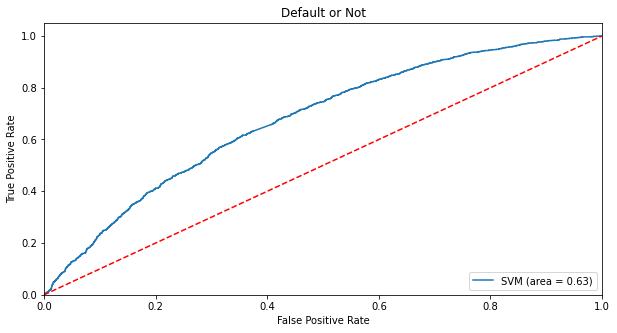

In [70]:
logit_roc_auc = roc_auc_score(y_test, model.predict(X_test))
fpr, tpr, thresholds = roc_curve(y_test, model.predict_proba(X_test)[:,1])
plt.figure(figsize=(10,5))
plt.plot(fpr, tpr, label='SVM (area = %0.2f)' % logit_roc_auc)
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Default or Not')
plt.legend(loc="lower right")
plt.savefig('Log_ROC')
plt.show()